In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Aca estan los datasets: https://github.com/bautiloisi/EpicareAI
df_train = pd.read_csv('raw182_Training_Relabeled_Auto_25.csv')
df_test = pd.read_csv('raw91_Testing_Relabeled_Auto_25.csv')
df_adl = pd.read_csv('Raw_Data_90ADL.csv')

In [ ]:
#Separar las features y normalizarlas
X_train = df_train.iloc[:, :3]
y_train = df_train.iloc[:, 3]

X_test = df_test.iloc[:, :3]
y_test = df_test.iloc[:, 3]

X_adl = df_adl.iloc[:, :3]
y_adl = df_adl.iloc[:, 3]

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_adl_scaled = scaler.fit_transform(X_adl)

In [ ]:
#Reshapear para hacer una lstm
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_adl_scaled = np.reshape(X_adl_scaled, (X_adl_scaled.shape[0], X_adl_scaled.shape[1], 1))

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Definicion de lmodelo
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], 1)))  # Explicit input shape
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))

# Modelo con los weights
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

Epoch 1/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7300 - loss: 0.6299 - val_accuracy: 0.6653 - val_loss: 0.6454
Epoch 2/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6547 - loss: 0.5854 - val_accuracy: 0.6677 - val_loss: 0.6101
Epoch 3/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6700 - loss: 0.5807 - val_accuracy: 0.6689 - val_loss: 0.5892
Epoch 4/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6807 - loss: 0.5575 - val_accuracy: 0.6768 - val_loss: 0.5774
Epoch 5/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7059 - loss: 0.5554 - val_accuracy: 0.7111 - val_loss: 0.5316
Epoch 6/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7129 - loss: 0.5591 - val_accuracy: 0.7300 - val_loss: 0.5067
Epoch 7/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7312 - loss: 0.5450 - val_accuracy: 0.7282 - val_loss: 0.5385
Epoch 8/20
851/851 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7419 - loss: 0.5512 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6953 - loss: 0.5933
Test Loss: 0.5851487517356873
Test Accuracy: 0.6875616908073425


In [ ]:
y_adl_pred = model.predict(X_adl_scaled)
y_adl_pred = (y_adl_pred > 0.5).astype(int)

print("Classification Report for ADL Data:")
print(classification_report(y_adl, y_adl_pred))

print("Confusion Matrix for ADL Data:")
print(confusion_matrix(y_adl, y_adl_pred))

1461/1461 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Classification Report for ADL Data:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62     29191
           1       0.45      0.62      0.52     17561

    accuracy                           0.57     46752
   macro avg       0.58      0.58      0.57     46752
weighted avg       0.61      0.57      0.58     46752

Confusion Matrix for ADL Data:
[[15952 13239]
 [ 6658 10903]]


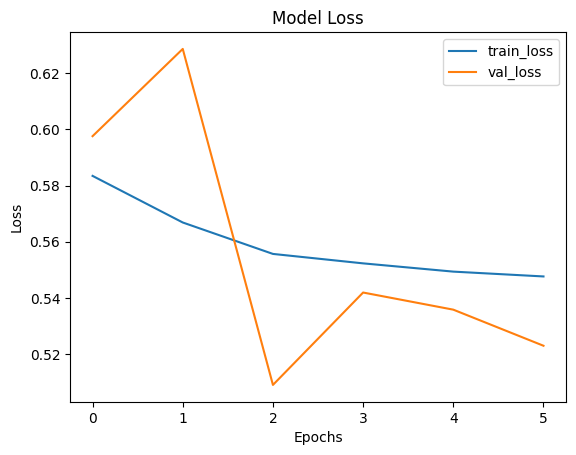

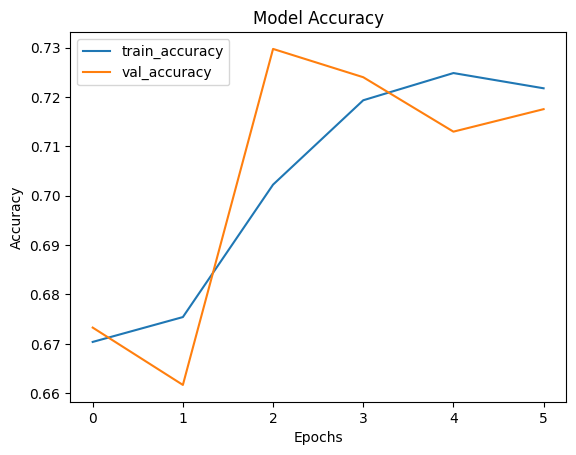

In [ ]:
# Plotear el historial de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()